# Real Data Example

Trey V. Wenger (c) August 2024

Here we demonstrate the basic `amoeba2` workflow applied to some real OH data.

In [ ]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import amoeba2
print("amoeba2 version:", amoeba2.__version__)

from amoeba2 import TauModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

## Load the Data

Our data are stored in a pickle file.

In [2]:
import pickle

with open("example_data.pkl", "rb") as f:
    real_data = pickle.load(f)
    
print(real_data.keys())

dict_keys(['coord', 'velocity_1612', 'tau_1612', 'velocity_1665', 'tau_1665', 'velocity_1667', 'tau_1667', 'velocity_1720', 'tau_1720'])


We pack the data into a `SpecData` dictionary.

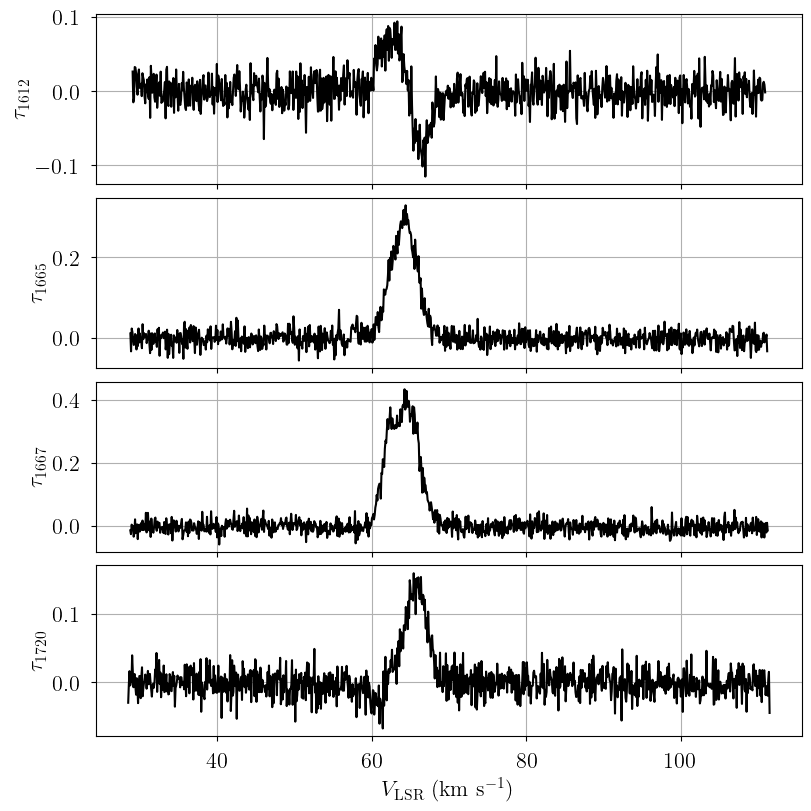

In [3]:
from bayes_spec import SpecData

data = {}
for transition in ["1612", "1665", "1667", "1720"]:
    # estimate rms
    med = np.median(real_data[f"tau_{transition}"])
    rms = 1.4826 * np.median(np.abs(real_data[f"tau_{transition}"] - med))
    data[f"tau_{transition}"] = SpecData(
        real_data[f"velocity_{transition}"],
        real_data[f"tau_{transition}"],
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau_{"+f"{transition}"+r"}$"
    )

# Plot the data
fig, axes = plt.subplots(4, sharex=True, layout="constrained", figsize=(8, 8))
for ax, datum in zip(axes, data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
_ = axes[-1].set_xlabel(datum.xlabel)

## Optimization

Now we determine the optimal number of clouds using the `TauModel`. It seems that the baselines are well-behaved, so we set `baseline_degree=0`. We update the velocity and rms priors to something reasonable for these data.

In [6]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    TauModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=0,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_log10_N_0 = [13.0, 1.0], # mean and width of log10(N_u) prior (cm-2)
    prior_inv_Tex = [0.0, 1.0], # mean and width of 1/Tex prior (K-1)
    prior_fwhm = 1.0, # mode of FWHM line width prior (km/s)
    prior_velocity = [65.0, 5.0], # mean and width of velocity prior (km/s)
    prior_rms_tau = 0.05, # width of optical depth rms prior
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

For speed, we approximate the posterior distributions using variational inference (`approx=True`), then sample the best model with MCMC.

In [7]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "tune": 1000,
    "draws": 1000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs, approx=True)

Null hypothesis BIC = 1.770e+03
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 4700
Interrupted at 4,699 [4%]: Average Loss = -7,311.8


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = -1.766e+04

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = -7,616.9


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -1.869e+04

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 4500
Interrupted at 4,499 [4%]: Average Loss = -7,529.8


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -1.892e+04

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 4900
Interrupted at 4,899 [4%]: Average Loss = -7,682.1


GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = -1.886e+04

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 5300
Interrupted at 5,299 [5%]: Average Loss = -7,661


GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = -1.882e+04

Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4500
Interrupted at 4,499 [4%]: Average Loss = -7,529.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_tau_1612_norm, baseline_tau_1665_norm, baseline_tau_1667_norm, baseline_tau_1720_norm, log10_N_0_norm, inv_Tex_free_norm, fwhm_norm, velocity_norm, rms_tau_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 903 seconds.


Only 3 chains appear converged.
There were 117 divergences in converged chains.
GMM converged to unique solution


In [8]:
az.summary(opt.best_model.trace.solution_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_tau_1612_norm[0],0.002,0.024,-0.040,0.048,0.000,0.000,3986.0,2134.0,1.0
baseline_tau_1665_norm[0],-0.262,0.011,-0.282,-0.239,0.000,0.000,3413.0,1664.0,1.0
baseline_tau_1667_norm[0],-0.287,0.008,-0.301,-0.270,0.000,0.000,3976.0,1876.0,1.0
baseline_tau_1720_norm[0],-0.186,0.020,-0.222,-0.149,0.000,0.000,3778.0,1807.0,1.0
fwhm[0],2.051,0.099,1.872,2.241,0.002,0.001,2736.0,1921.0,1.0
fwhm[1],3.598,0.241,3.140,3.969,0.008,0.006,951.0,1720.0,1.0
fwhm[2],2.977,0.181,2.666,3.329,0.004,0.003,1978.0,1557.0,1.0
fwhm_norm[0],2.051,0.099,1.872,2.241,0.002,0.001,2736.0,1921.0,1.0
fwhm_norm[1],3.598,0.241,3.140,3.969,0.008,0.006,951.0,1720.0,1.0
fwhm_norm[2],2.977,0.181,2.666,3.329,0.004,0.003,1978.0,1557.0,1.0


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [tau_1612, tau_1665, tau_1667, tau_1720]


Output()

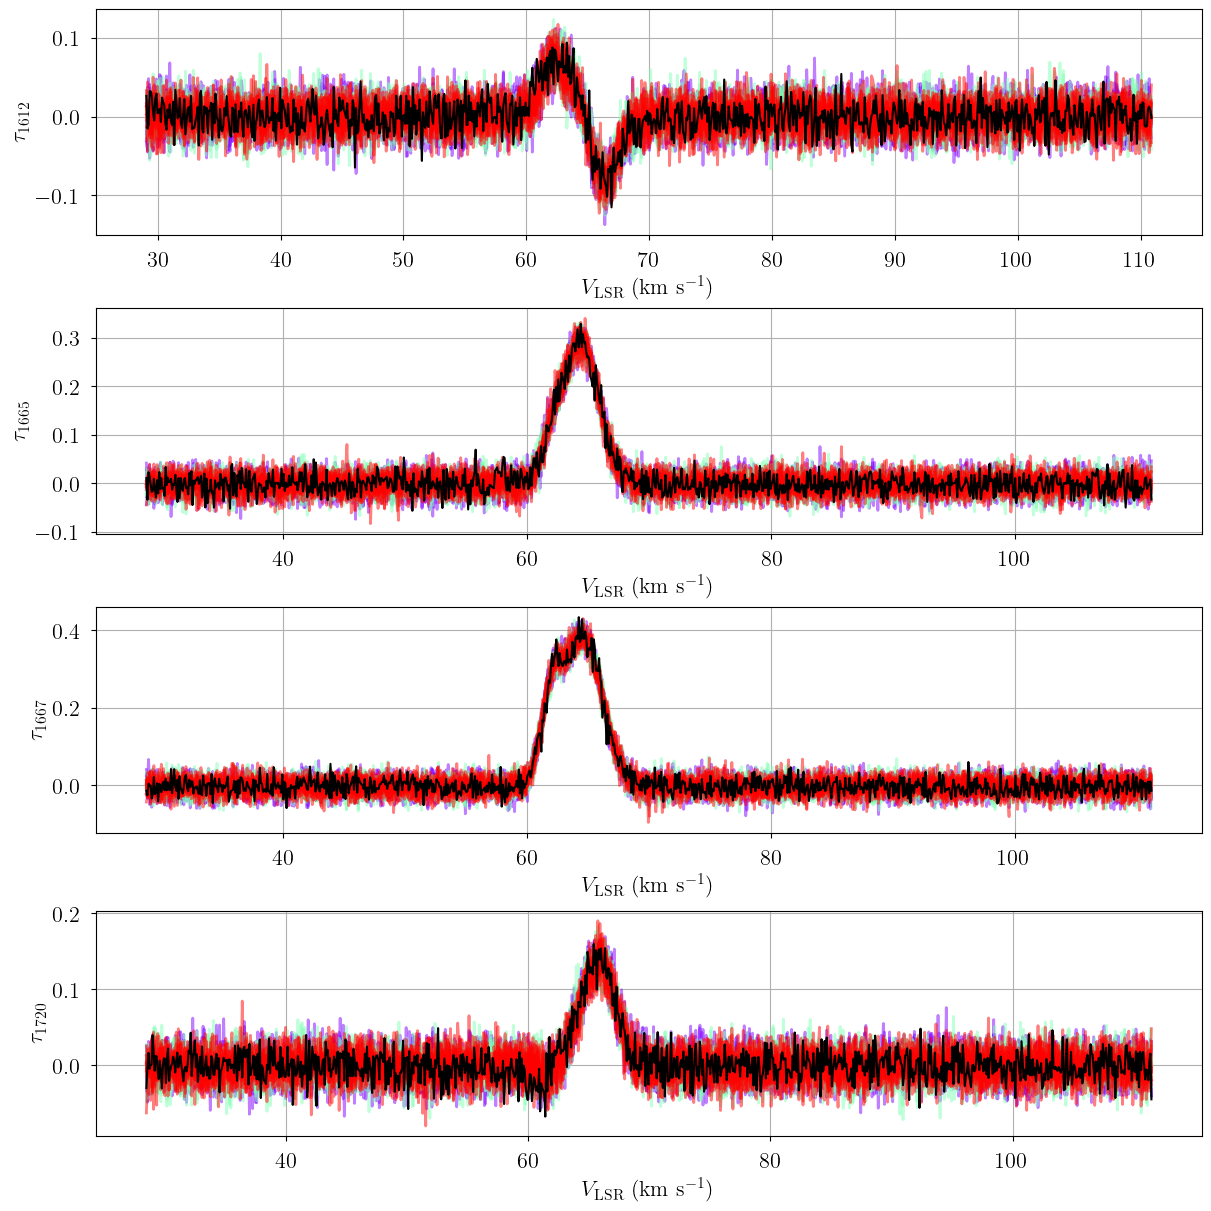

In [11]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(opt.best_model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(12, 12)

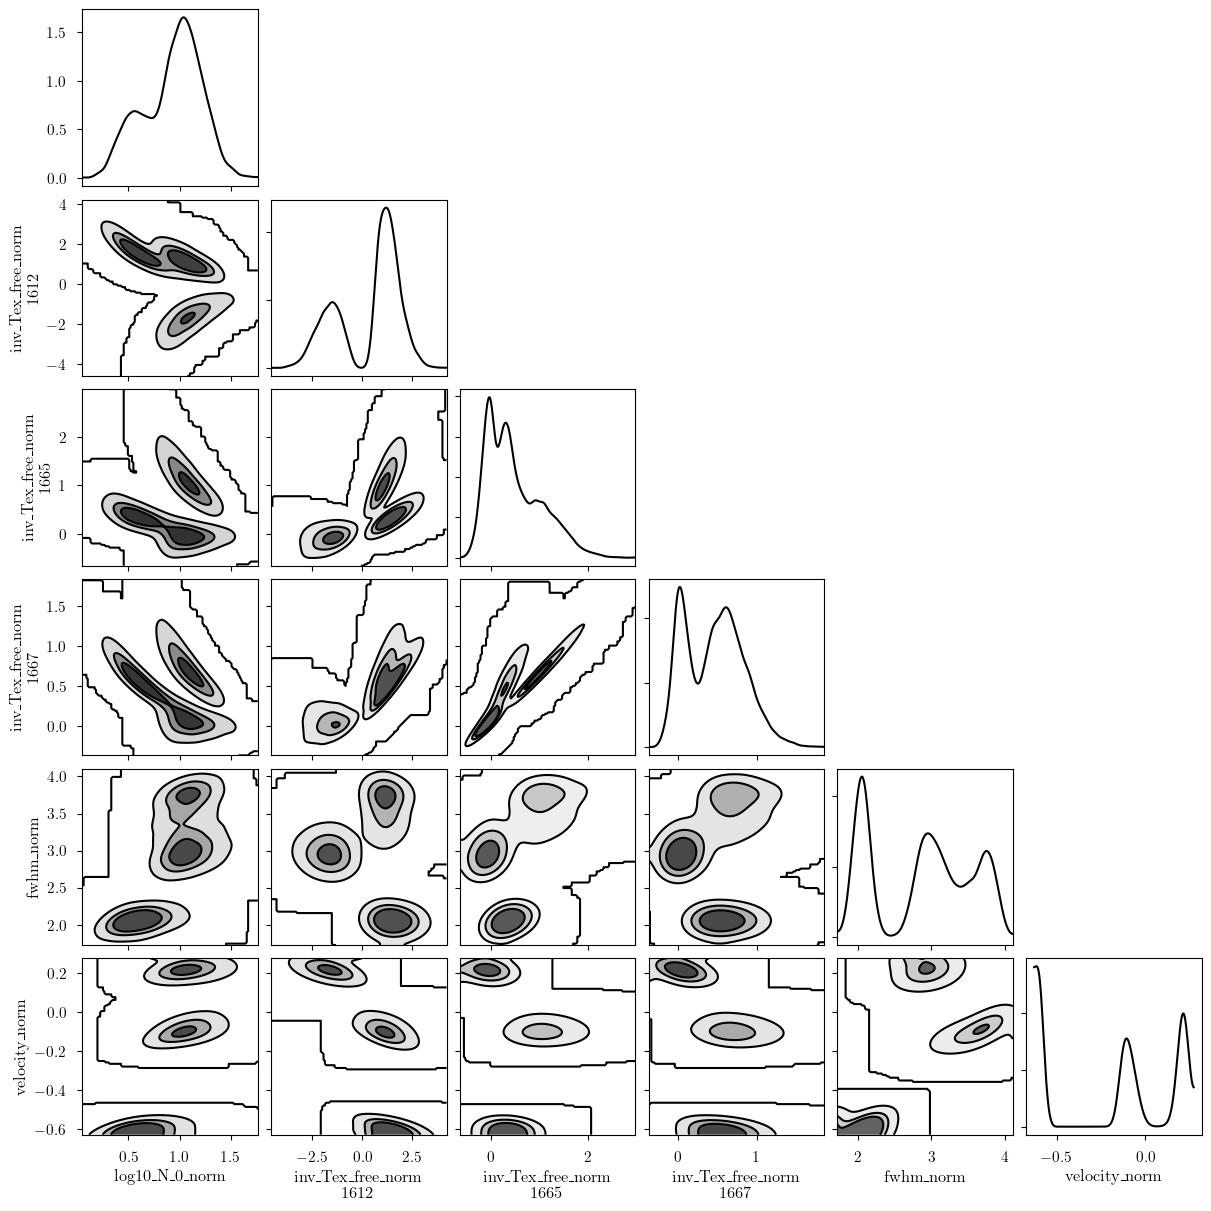

In [12]:
from bayes_spec.plots import plot_pair

axes = plot_pair(
    opt.best_model.trace.solution_0, # samples
    opt.best_model.cloud_freeRVs, # var_names to plot
    labeller=opt.best_model.labeller, # label manager
)
axes.ravel()[0].figure.set_size_inches(12, 12)